## Imports

In [15]:
import logging
import os
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
import torch.autograd as autograd
import seaborn as sns
import numpy as np
import imageio
import shutil
from tqdm.notebook import tqdm

sns.set()
sns.set_style('white')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

left_bound = -8
right_bound = 8

### Visualization functions

In [16]:
def get_mesh(left_bound, right_bound, grid_size=100, device=None):
    x = np.linspace(left_bound, right_bound, grid_size)
    y = np.linspace(left_bound, right_bound, grid_size)
    mesh = []
    for i in x:
        for j in y:
            mesh.append(np.asarray([i, j]))
    mesh = np.stack(mesh, axis=0)
    mesh = torch.from_numpy(mesh).float()
    if device is not None:
        mesh = mesh.to(device)
    return mesh

def plot_density(teacher, left_bound, right_bound, ax=None, device=None):
    mesh = get_mesh(left_bound, right_bound, grid_size=100, device=device)
    logp_true = teacher.log_prob(mesh)
    logp_true = logp_true.view(100, 100).exp()

    if ax is None:
        fig, ax = plt.subplots()
    
    ax.axis('off')
    ax.imshow(np.flipud(logp_true.cpu().numpy()), cmap='inferno', extent=[left_bound, right_bound, left_bound, right_bound])
    ax.set_title('Data density')

def plot_vector_field(scores, mesh_np, title, ax=None, teacher=None, samples=None, sigma=None, left_bound=None, right_bound=None, device=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    if samples is not None:
        sns.kdeplot(x=samples[:, 0], y=samples[:, 1], ax=ax, cmap='Reds', fill=True, alpha=0.5, levels=15)
        if left_bound is not None and right_bound is not None:
            ax.set_xlim(left_bound, right_bound)
            ax.set_ylim(left_bound, right_bound)

    elif teacher is not None and left_bound is not None and right_bound is not None:
        mesh_density = get_mesh(left_bound, right_bound, grid_size=100, device=device)
        if sigma is not None:
             logp_true = teacher.log_prob(mesh_density, sigma=sigma)
        else:
             logp_true = teacher.log_prob(mesh_density)
             
        logp_true = logp_true.view(100, 100).exp().detach().cpu().numpy()
        
        x = np.linspace(left_bound, right_bound, 100)
        y = np.linspace(left_bound, right_bound, 100)
        X, Y = np.meshgrid(x, y)
        
        ax.contourf(X, Y, logp_true, cmap='Reds', levels=15, alpha=0.6)

    ax.axis('off')
    ax.quiver(mesh_np[:, 0], mesh_np[:, 1], scores[:, 0], scores[:, 1], width=0.005, headwidth=4, headlength=4, color='black', alpha=0.3)
    ax.set_title(title)
    ax.set_aspect('equal')

def plot_scatter(samples, title, left_bound, right_bound, ax=None, s=0.1):
    if ax is None:
        fig, ax = plt.subplots()
        
    ax.scatter(samples[:, 0], samples[:, 1], s=s)
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.set_xlim([left_bound, right_bound])
    ax.set_ylim([left_bound, right_bound])

### Data distributions

We use two simple 2D toy datasets: a mixture of two Gaussians and a ring of Gaussians.

**1. Mixture of Two Gaussians (`GMMDist` with `dist_type='2gauss'`)**
The data distribution $p_{data}(\mathbf{x})$ is defined as:
$$p_{data}(\mathbf{x}) = 0.8 \cdot \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_1, I) + 0.2 \cdot \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_2, I)$$
where $\boldsymbol{\mu}_1 = (5, 5)$ and $\boldsymbol{\mu}_2 = (-5, -5)$.

**2. Ring of Gaussians (`GMMDist` with `dist_type='ring'`)**
The data distribution consists of 8 Gaussians arranged in a circle of radius 5.
$$p_{data}(\mathbf{x}) = \frac{1}{8} \sum_{i=1}^8 \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_i, I)$$
where $\boldsymbol{\mu}_i = (5 \cos(\theta_i), 5 \sin(\theta_i))$ and $\theta_i = \frac{2\pi i}{8}$.

In [17]:
class GMMDist(object):
    def __init__(self, dim, dist_type='2gauss', radius=5.0, n_components=8):
        self.dist_type = dist_type
        self.dim = dim
        if dist_type == '2gauss':
            self.mix_probs = torch.tensor([0.8, 0.2])
            self.means = torch.stack([5 * torch.ones(dim), -torch.ones(dim) * 5], dim=0)
        elif dist_type == 'ring':
            self.mix_probs = torch.ones(n_components) / n_components
            angles = torch.linspace(0, 2 * np.pi, n_components + 1)[:-1]
            self.means = torch.stack([radius * torch.cos(angles), radius * torch.sin(angles)], dim=1)
        
        self.sigma = 1
        self.std = torch.stack([torch.ones(dim) * self.sigma for i in range(len(self.mix_probs))], dim=0)

    def sample(self, n):
        n = n[0]
        mix_idx = torch.multinomial(self.mix_probs, n, replacement=True)
        means = self.means[mix_idx]
        stds = self.std[mix_idx]
        return torch.randn_like(means) * stds + means

    def log_prob(self, samples):
        device = samples.device
        means = self.means.to(device)
        mix_probs = self.mix_probs.to(device)
        stds = self.std.to(device)
        logps = []
        for i in range(len(mix_probs)):
            logps.append((-((samples - means[i]) ** 2).sum(dim=-1) / (2 * stds[i][0] ** 2) - 0.5 * np.log(
                2 * np.pi * stds[i][0] ** 2)) + mix_probs[i].log())
        logp = torch.logsumexp(torch.stack(logps, dim=0), dim=0)
        return logp

**3. Annealed Distribution (`GMMDistAnneal` with `dist_type='2gauss'` or `'ring'`)**
For the annealed Langevin dynamics, we consider a sequence of noise levels $\sigma_1 > \sigma_2 > \dots > \sigma_L$. The perturbed distributions are modeled similarly to the data distributions but with variance $\sigma^2 I$ instead of $I$.
This class allows us to compute the log-probability and score (gradient of log-prob) at any given noise level $\sigma$, which serves as the ground truth for evaluating our score network.

In [18]:
class GMMDistAnneal(object):
    def __init__(self, dim, dist_type='2gauss', radius=5.0, n_components=8):
        self.dist_type = dist_type
        self.dim = dim
        if dist_type == '2gauss':
            self.mix_probs = torch.tensor([0.8, 0.2])
            self.means = torch.stack([5 * torch.ones(dim), -torch.ones(dim) * 5], dim=0)
        elif dist_type == 'ring':
            self.mix_probs = torch.ones(n_components) / n_components
            angles = torch.linspace(0, 2 * np.pi, n_components + 1)[:-1]
            self.means = torch.stack([radius * torch.cos(angles), radius * torch.sin(angles)], dim=1)
        self.sigma = 1

    def sample(self, n, sigma=1):
        n = n[0]
        mix_idx = torch.multinomial(self.mix_probs, n, replacement=True)
        means = self.means[mix_idx]
        return torch.randn_like(means) * sigma + means


    def log_prob(self, samples, sigma=1):
        device = samples.device
        means = self.means.to(device)
        mix_probs = self.mix_probs.to(device)
        
        if isinstance(sigma, torch.Tensor):
            log_term = torch.log(2 * np.pi * sigma ** 2)
        else:
            log_term = np.log(2 * np.pi * sigma ** 2)
            
        logps = []
        for i in range(len(mix_probs)):
            logps.append((-((samples - means[i]) ** 2).sum(dim=-1) / (2 * sigma ** 2) - 0.5 * log_term) + mix_probs[i].log())
        logp = torch.logsumexp(torch.stack(logps, dim=0), dim=0)
        return logp

    def score(self, samples, sigma=1):
        with torch.enable_grad():
            samples = samples.detach()
            samples.requires_grad_(True)
            log_probs = self.log_prob(samples, sigma).sum()
            return autograd.grad(log_probs, samples)[0]

## Noise Conditional Score Networks

### Denoising Score Matching (Eq. 2)

The objective function for Denoising Score Matching is given by:

$$J_{DSM}(\theta) = \frac{1}{2} \mathbb{E}_{q_\sigma(\tilde{x}|x)p_{data}(x)} [ || s_\theta(\tilde{x}) - \nabla_{\tilde{x}} \log q_\sigma(\tilde{x}|x) ||_2^2 ]$$

where $\nabla_{\tilde{x}} \log q_\sigma(\tilde{x}|x) = \frac{x - \tilde{x}}{\sigma^2}$ for Gaussian noise.

In [19]:
def dsm_score_estimation(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma                                     # generate x_tilde
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)                                         # calculate (x - x_tilde) / sigma**2
    scores = scorenet(perturbed_samples)                                                                # calculate s_\theta(x_tilde)
    target = target.view(target.shape[0], -1)                           
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)                                    # calculate 1/2 * (s_\theta - gradient)

    return loss

### Annealed Denoising Score Matching (Eq. 5)

The annealed objective function is:

$$\mathcal{L}(\theta; \{ \sigma_i \}_{i=1}^L) = \frac{1}{L} \sum_{i=1}^L \lambda(\sigma_i) \mathbb{E}_{p_{data}(x)} \mathbb{E}_{q_{\sigma_i}(\tilde{x}|x)} [ || s_\theta(\tilde{x}, \sigma_i) + \frac{\tilde{x} - x}{\sigma_i^2} ||_2^2 ]$$

where $\lambda(\sigma_i) = \sigma_i^2$.

In [20]:
def anneal_dsm_score_estimation(scorenet, samples, labels, sigmas, anneal_power=2.):
    used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))                # select sigma for each sample
    perturbed_samples = samples + torch.randn_like(samples) * used_sigmas                               # generate x_tilde
    target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)                                   # calculate (x - x_tilde) / sigma**2
    scores = scorenet(perturbed_samples, labels)                                                        # calculate s_\theta(x_tilde, sigma)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power        # calculate 1/2 * (s_\theta - gradient) * sigma**2

    return loss.mean(dim=0)

### Langevin Dynamics

The standard Langevin dynamics update rule is:
$$\tilde{x}_t = \tilde{x}_{t-1} + \frac{\epsilon}{2} \nabla_x \log p(\tilde{x}_{t-1}) + \sqrt{\epsilon} z_t$$

In [21]:
def langevin_dynamics(score, init, lr=0.1, step=1000):
    for i in range(step):
        current_lr = lr
        init = init + current_lr / 2 * score(init).detach()                                             # score (gradient) of the previous time step
        init = init + torch.randn_like(init) * np.sqrt(current_lr)                                      # added noise
    return init

### Annealed Langevin Dynamics (Algorithm 1 & Eq. 4)

**Algorithm 1: Annealed Langevin Dynamics**

1. **Input:** $\{ \sigma_i \}_{i=1}^L, \epsilon, T$
2. **Initialize** $\tilde{x}_0$
3. **For** $i = 1$ **to** $L$ **do**
    * $\alpha_i \leftarrow \epsilon \cdot \sigma_i^2 / \sigma_L^2$
    * **For** $t = 1$ **to** $T$ **do**
        * Draw $z_t \sim \mathcal{N}(0, I)$
        * $\tilde{x}_t \leftarrow \tilde{x}_{t-1} + \frac{\alpha_i}{2} s_\theta(\tilde{x}_{t-1}, \sigma_i) + \sqrt{\alpha_i} z_t$
    * **End For**
    * $\tilde{x}_0 \leftarrow \tilde{x}_T$
4. **End For**
5. **Output** $\tilde{x}_T$

The update rule (Eq. 4) is:
$$\tilde{x}_t = \tilde{x}_{t-1} + \frac{\alpha_i}{2} s_\theta(\tilde{x}_{t-1}, \sigma_i) + \sqrt{\alpha_i} z_t$$

In [22]:
def anneal_langevin_dynamics(score, init, sigmas, lr=0.1, n_steps_each=100):
    for sigma in sigmas:
        for i in range(n_steps_each):
            current_lr = lr * (sigma / sigmas[-1]) ** 2                                                 # calculate the learning rate based on current noise step
            init = init + current_lr / 2 * score(init, sigma).detach()                                  # add the (diminishing lr-weighted) score from prev step
            init = init + torch.randn_like(init) * torch.sqrt(current_lr)                               # add noise based on current step

    return init

### Conditional Score 

The model must be conditioned on the noise level - `ConditionalScoreNet` takes both the data $x$ and the noise level index `labels` as input.
* Learn a function $s_\theta(x, \sigma)$ that can output the correct score for *any* of the trained noise levels.
* The input and output of the model are in the same number of dimensions.

In [23]:
class ConditionalScoreNet(nn.Module):
    def __init__(self, n_classes, hidden_units=128):
        super().__init__()
        self.embed = nn.Embedding(n_classes, hidden_units)
        self.main = nn.Sequential(
            nn.Linear(2 + hidden_units, hidden_units),
            nn.Softplus(),
            nn.Linear(hidden_units, hidden_units),
            nn.Softplus(),
            nn.Linear(hidden_units, 2),
        )

    def forward(self, x, labels):
        embed = self.embed(labels)
        x = torch.cat([x, embed], dim=-1)
        return self.main(x)

## Model Training + Visualization

### Training: Non-annealed Langevin

In [24]:
def train_langevin_model(teacher, n_steps=10000, hidden_units=128, lr=0.001):
    score = nn.Sequential(
        nn.Linear(2, hidden_units),
        nn.Softplus(),
        nn.Linear(hidden_units, hidden_units),
        nn.Softplus(),
        nn.Linear(hidden_units, 2),
    )
    
    optimizer = optim.Adam(score.parameters(), lr=lr)
    loss_history = []
    pbar = tqdm(range(n_steps))

    for step in pbar:
        samples = teacher.sample((128,))
        loss = dsm_score_estimation(score, samples, sigma=1.)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        if step % 100 == 0:
            pbar.set_description(f"Loss: {loss.item():.4f}")
            
    # Plot loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(loss_history)
    plt.title("Training Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.show()
    
    return score

### Training: Annealed Langevin

In [25]:
def train_annealed_langevin_model(teacher_anneal, sigmas, n_steps=10000, hidden_units=128, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    score_anneal = ConditionalScoreNet(n_classes=len(sigmas), hidden_units=hidden_units).to(device)
    optimizer_anneal = optim.Adam(score_anneal.parameters(), lr=lr)
    
    sigma_losses = {i: [] for i in range(len(sigmas))}
    pbar = tqdm(range(n_steps))

    for step in pbar:
        samples = teacher_anneal.sample((128,)).to(device)
        labels = torch.randint(0, len(sigmas), (128,)).to(device)
        
        used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
        perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
        target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)
        scores = score_anneal(perturbed_samples, labels)
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)
        loss_vec = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** 2
        loss = loss_vec.mean()

        optimizer_anneal.zero_grad()
        loss.backward()
        optimizer_anneal.step()

        loss_vals = loss_vec.detach().cpu().numpy()
        label_vals = labels.detach().cpu().numpy()
        for l, v in zip(label_vals, loss_vals):
            sigma_losses[l].append(v)

        if step % 100 == 0:
            pbar.set_description(f"Loss: {loss.item():.4f}")
            
    # Plot loss curves
    plt.figure(figsize=(12, 6))
    plot_indices = np.linspace(0, len(sigmas)-1, 10).astype(int)
    for idx in plot_indices:
        losses = sigma_losses[idx]
        window = 100
        if len(losses) > window:
            smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
            plt.plot(smoothed, label=f'Sigma={sigmas[idx].item():.2f}')
        else:
            plt.plot(losses, label=f'Sigma={sigmas[idx].item():.2f}')
    plt.legend()
    plt.title("Training Loss per Sigma (Smoothed)")
    plt.xlabel("Occurrence")
    plt.ylabel("Loss")
    plt.show()
    
    return score_anneal

### Visualization: Non-annealed Langevin

In [26]:
def visualize_langevin_model(score, teacher, left_bound, right_bound):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    # Prepare mesh for vector fields
    mesh = get_mesh(left_bound, right_bound, grid_size=20, device='cpu')
    mesh_np = mesh.detach().cpu().numpy()

    # 1. Data Density
    plot_density(teacher, left_bound, right_bound, ax=axes[0], device='cpu')

    # 2. Data Samples
    samples = teacher.sample((1280,)).detach().cpu().numpy()
    plot_scatter(samples, 'Data samples', left_bound, right_bound, ax=axes[1])

    # 3. Data Scores (Ground Truth)
    def data_score(x):
        x = x.detach()
        x.requires_grad_(True)
        y = teacher.log_prob(x).sum()
        return autograd.grad(y, x)[0]

    scores = data_score(mesh).detach().cpu().numpy()
    plot_vector_field(scores, mesh_np, 'Data scores', ax=axes[2], teacher=teacher, left_bound=left_bound, right_bound=right_bound, device='cpu')

    # 4. Langevin Dynamics (Data)
    samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
    samples = langevin_dynamics(data_score, samples).detach().numpy()
    plot_scatter(samples, 'Langevin dynamics (Data)', left_bound, right_bound, ax=axes[3])

    # 5. Langevin Dynamics (Model)
    samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
    samples = langevin_dynamics(score, samples).detach().numpy()
    plot_scatter(samples, 'Langevin dynamics (Model)', left_bound, right_bound, ax=axes[4])

    # 6. Estimated Scores
    scores = score(mesh.detach()).detach().cpu().numpy()
    plot_vector_field(scores, mesh_np, 'Estimated scores', ax=axes[5], samples=samples, left_bound=left_bound, right_bound=right_bound)

    plt.tight_layout()
    plt.show()

### Visualization: Annealed Langevin

In [27]:
def visualize_annealed_langevin_model(score_anneal, teacher_anneal, sigmas, left_bound, right_bound, save_name='annealed_scores.gif'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def trained_score_fn(x, sigma):
        diff = (sigmas - sigma).abs()
        label = torch.argmin(diff)
        labels = torch.ones(x.shape[0], dtype=torch.long).to(device) * label
        return score_anneal(x, labels)

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes = axes.flatten()

    mesh = get_mesh(left_bound, right_bound, grid_size=20, device=device)
    mesh_np = mesh.detach().cpu().numpy()

    # 1. Standard Langevin Dynamics Samples (using smallest sigma)
    samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
    if device is not None:
        samples = samples.to(device)
    score_fn_smallest = lambda x: trained_score_fn(x, sigmas[-1])
    samples = langevin_dynamics(score_fn_smallest, samples).detach().cpu().numpy()
    plot_scatter(samples, 'Langevin dynamics samples', left_bound, right_bound, ax=axes[0], s=0.2)

    # 2. Annealed Langevin Dynamics Samples
    samples = torch.rand(1280, 2) * (right_bound - left_bound) + left_bound
    if device is not None:
        samples = samples.to(device)
    samples = anneal_langevin_dynamics(trained_score_fn, samples, sigmas).detach().cpu().numpy()
    plot_scatter(samples, 'Annealed Langevin dynamics samples', left_bound, right_bound, ax=axes[1], s=0.2)

    # 3. Vector field (Largest Sigma)
    sigma_large = sigmas[0]
    scores_large = trained_score_fn(mesh, sigma_large).detach().cpu().numpy()
    plot_vector_field(scores_large, mesh_np, 'Scores (sigma={:.2f})'.format(sigma_large), ax=axes[2], teacher=teacher_anneal, sigma=sigma_large, left_bound=left_bound, right_bound=right_bound, device=device)

    # 4. Vector field (Smallest Sigma)
    sigma_small = sigmas[-1]
    scores_small = trained_score_fn(mesh, sigma_small).detach().cpu().numpy()
    plot_vector_field(scores_small, mesh_np, 'Scores (sigma={:.2f})'.format(sigma_small), ax=axes[3], teacher=teacher_anneal, sigma=sigma_small, left_bound=left_bound, right_bound=right_bound, device=device)

    plt.tight_layout()
    plt.show()
    
    # Visualize scores for 10 different noise scales
    fig, axes = plt.subplots(1, 10, figsize=(20, 2))
    axes = axes.flatten()
    indices = np.linspace(0, len(sigmas) - 1, 10).astype(int)
    for i, idx in enumerate(indices):
        sigma = sigmas[idx]
        scores = trained_score_fn(mesh, sigma).detach().cpu().numpy()
        plot_vector_field(scores, mesh_np, '$\sigma={:.2f}$'.format(sigma.item()), ax=axes[i],
                          teacher=teacher_anneal, sigma=sigma, left_bound=left_bound, right_bound=right_bound, device=device)
    plt.tight_layout()
    plt.show()

    # GIF generation
    images = []
    if not os.path.exists('tmp_gif'):
        os.makedirs('tmp_gif')

    print("Generating GIF...")
    for i, sigma in enumerate(sigmas):
        scores = trained_score_fn(mesh, sigma).detach().cpu().numpy()
        
        fig_gif, ax_gif = plt.subplots()
        plot_vector_field(scores, mesh_np, 'Scores (sigma={:.2f})'.format(sigma), ax=ax_gif, teacher=teacher_anneal, sigma=sigma, left_bound=left_bound, right_bound=right_bound, device=device)
        filename = f'tmp_gif/sigma_{i}.png'
        fig_gif.savefig(filename)
        plt.close(fig_gif)
        images.append(imageio.imread(filename))

    imageio.mimsave(save_name, images, duration=0.2)
    print(f"GIF saved as {save_name}")

    # Clean up tmp files
    shutil.rmtree('tmp_gif')

## Experiments

### Two Gaussians Dataset

#### Langevin dynamics (single noise scale)

Train the model and plot the loss curve over steps

  0%|          | 0/10000 [00:00<?, ?it/s]

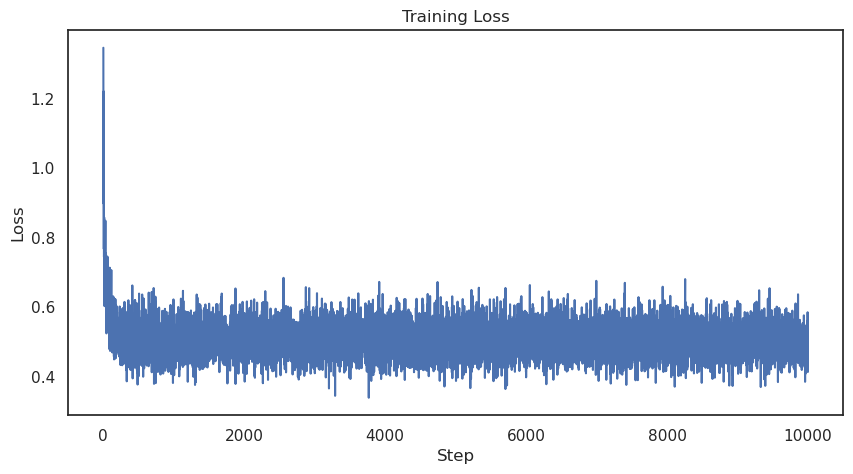

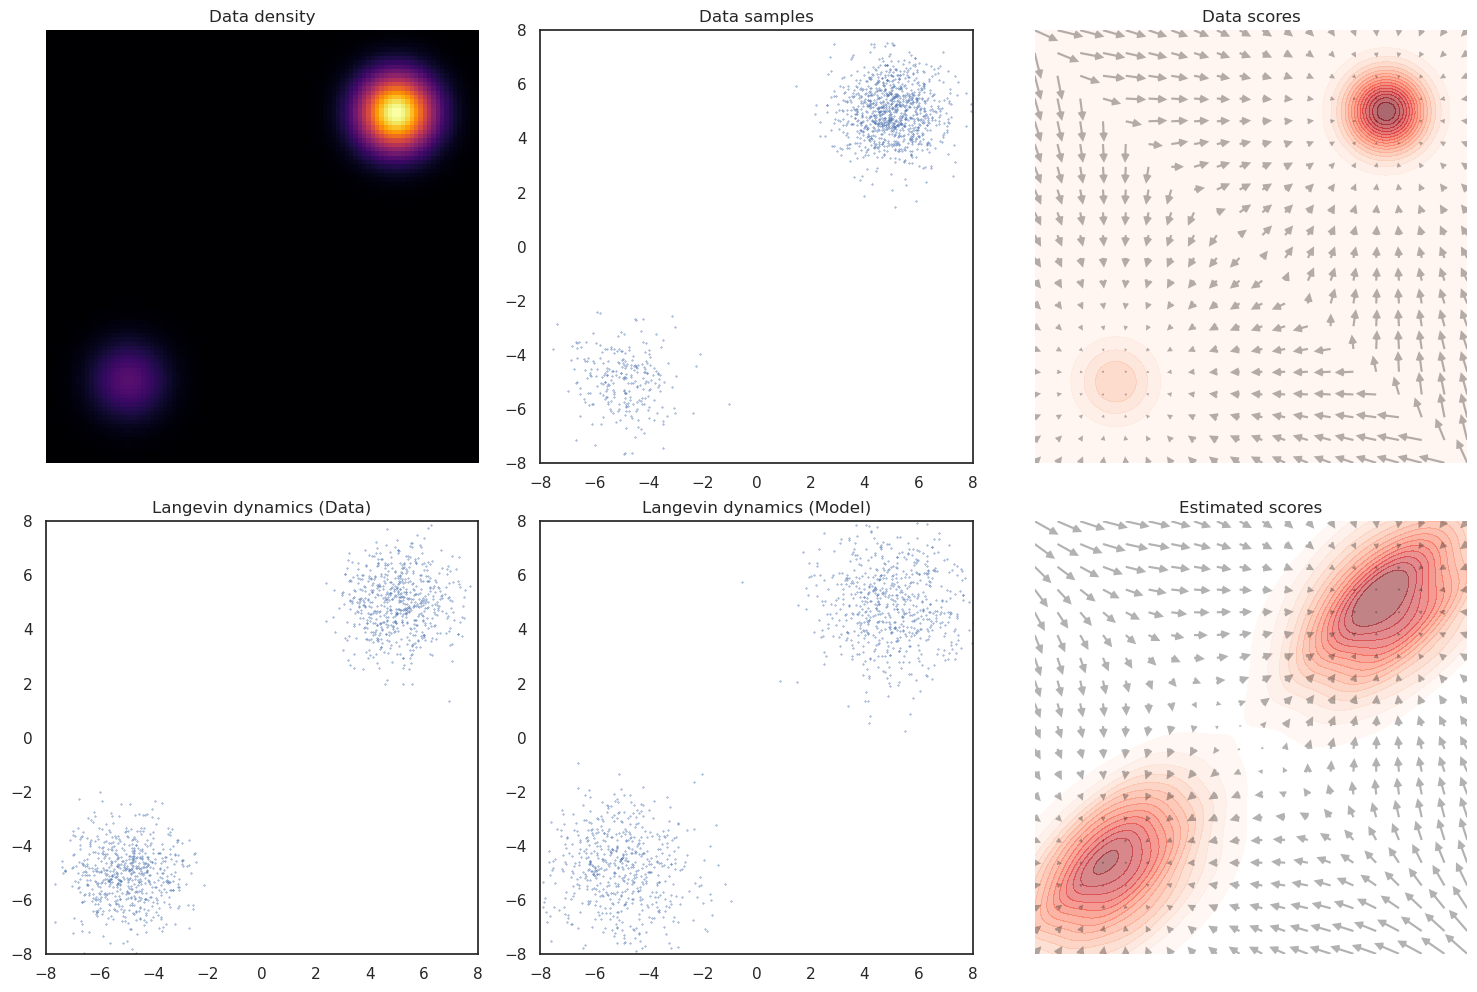

In [28]:
teacher = GMMDist(dim=2, dist_type='2gauss')
score = train_langevin_model(teacher)
visualize_langevin_model(score, teacher, left_bound, right_bound)

Results of the non-annealed Langevin dynamics model. Remarks:
* The data score is more concentrated towards the two Gaussian, especially the $0.8$-weighted Gaussian. The gradient is evenly distributed across the space otherwise (as remarked in Fig. 2 of the paper).
* The model's Langevin samplings of the two Gaussians looks more even than the $1:4$ ratio of the ground truth dataset.
* The model's learned score function is also more even between the two Gaussians, confirming the intuition from the original paper that original Langevin does not sample the space evenly enough to avoid mode-collapse.

#### Annealed Langevin dynamics

Using device: cuda


  0%|          | 0/10000 [00:00<?, ?it/s]

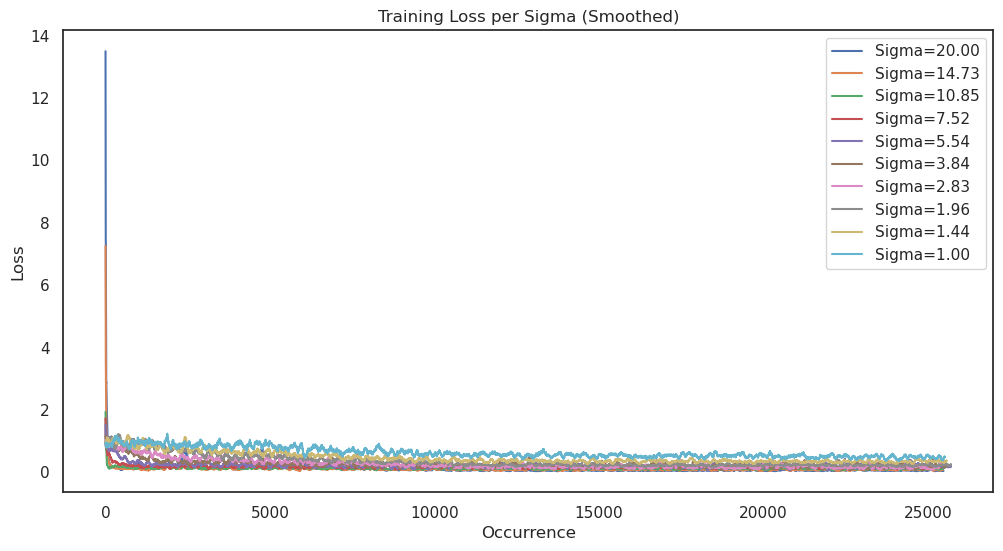

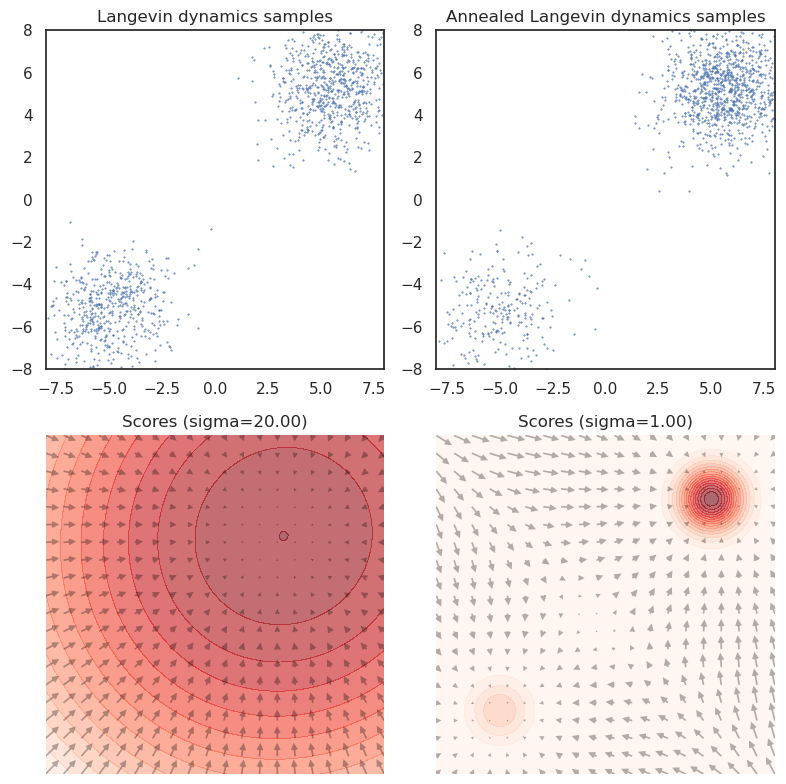

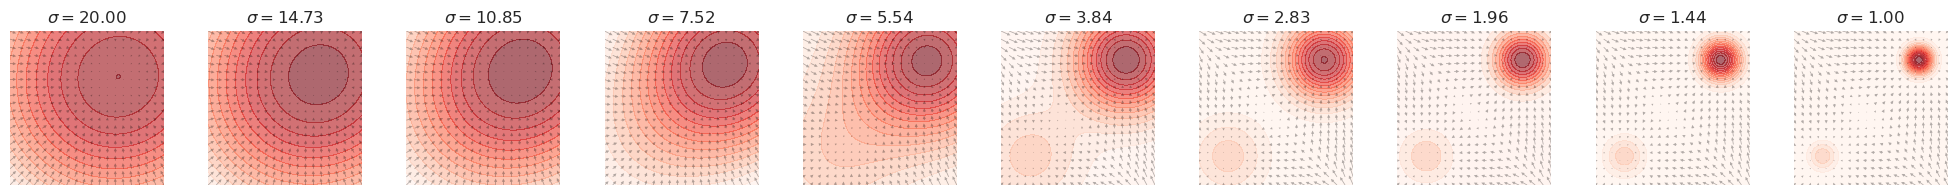

Generating GIF...


/tmp/ipykernel_810178/935653853.py:70: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved as annealed_scores_2gauss.gif


In [29]:
teacher_anneal = GMMDistAnneal(dim=2, dist_type='2gauss')
sigmas = torch.tensor(np.exp(np.linspace(np.log(20), 0., 50))).float().to(device)
score_anneal = train_annealed_langevin_model(teacher_anneal, sigmas)
visualize_annealed_langevin_model(score_anneal, teacher_anneal, sigmas, left_bound, right_bound, save_name='annealed_scores_2gauss.gif')

Results of the annealed Langevin dynamics model. Remarks:
* The model's annealed Langevin samplings of the two Gaussians look closer to the unbalanced $1:4$ ratio of the ground truth dataset.
* The model's learned multiple score functions of the two Gaussian, with larger noise scale starting from the more heavily weighted Gaussian. The weaker Gaussian starts appearing with finer noises, so the annealed collection of score functions can still identify it.
* The finest noise scale score function has greater losses than the other noise scales, possibly also due to mode collapse for this singular noise value. This does not matter in the entire model, as the model works with the score functions of all learned noise scales.
* Even for the lowest noise scale, the sampling from score function appears more even than the non-annealed case.

### Gaussian Ring Dataset

#### Langevin dynamics (single noise scale)

  0%|          | 0/10000 [00:00<?, ?it/s]

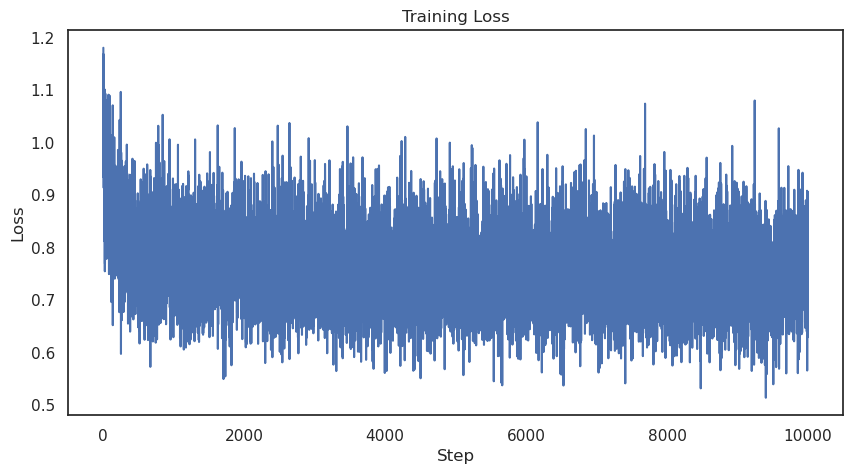

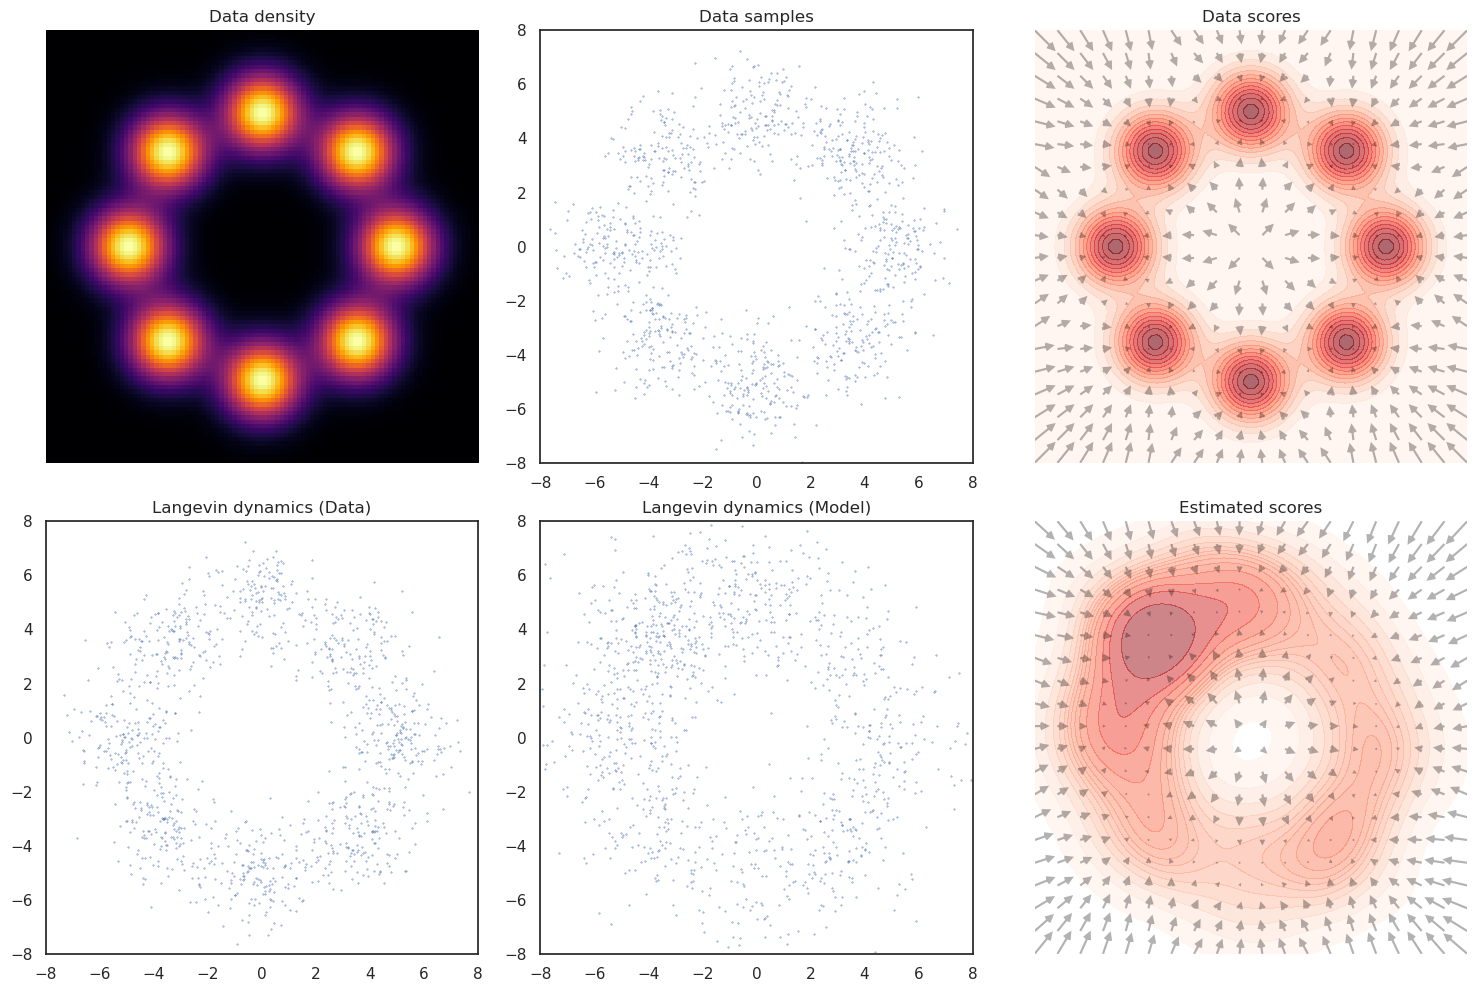

In [30]:
teacher_ring = GMMDist(dim=2, dist_type='ring')
score_ring = train_langevin_model(teacher_ring)
visualize_langevin_model(score_ring, teacher_ring, left_bound, right_bound)

Results of the non-annealed Langevin dynamics model on the Ring dataset. Remarks:
*   The model struggles to traverse between the different modes of the ring distribution.
*   The samples are often stuck in a subset of the 8 Gaussians, failing to cover the entire distribution.
*   This illustrates the difficulty of standard Langevin dynamics in mixing between separated modes, even when they are symmetric.

#### Annealed Langevin dynamics

Using device: cuda


  0%|          | 0/10000 [00:00<?, ?it/s]

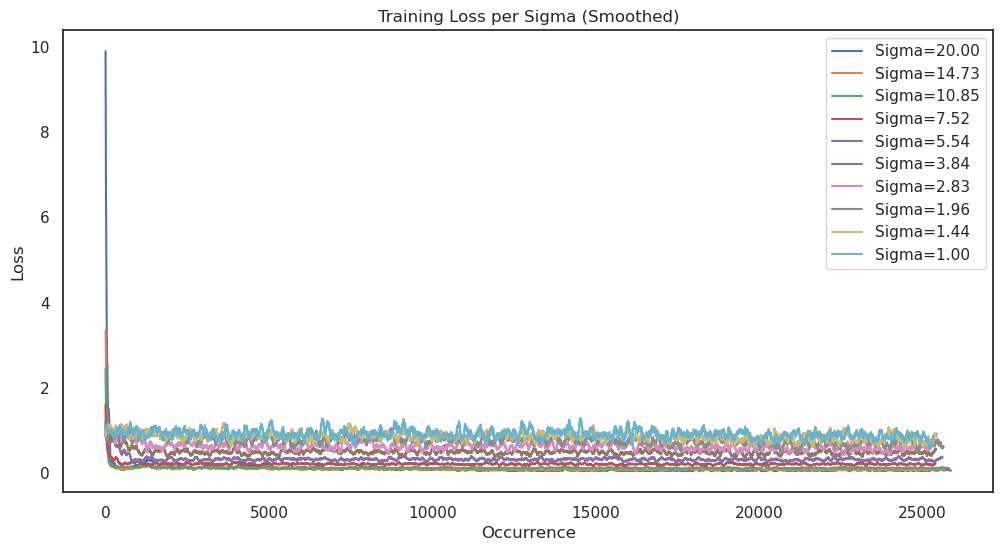

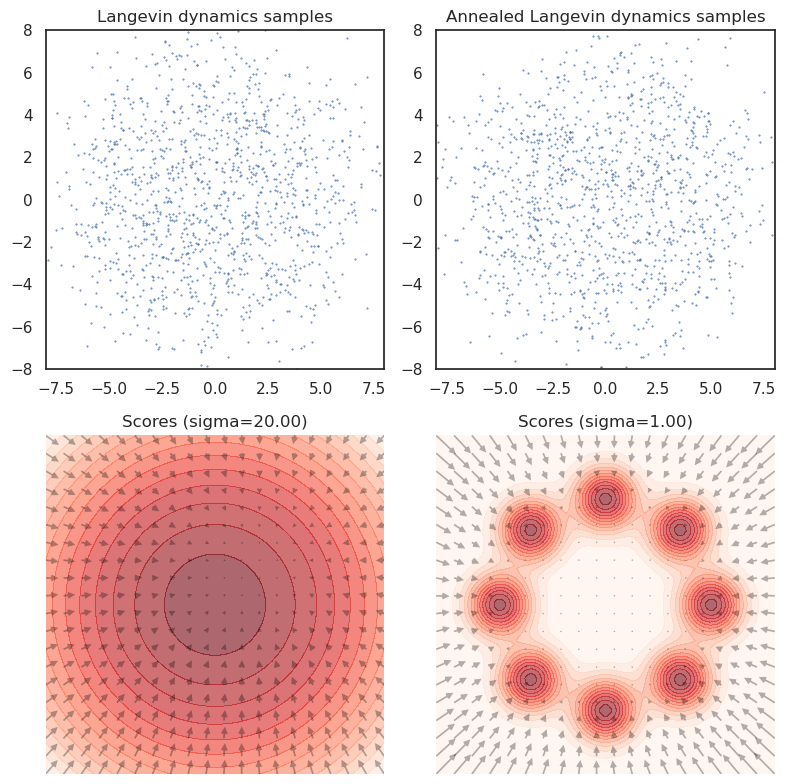

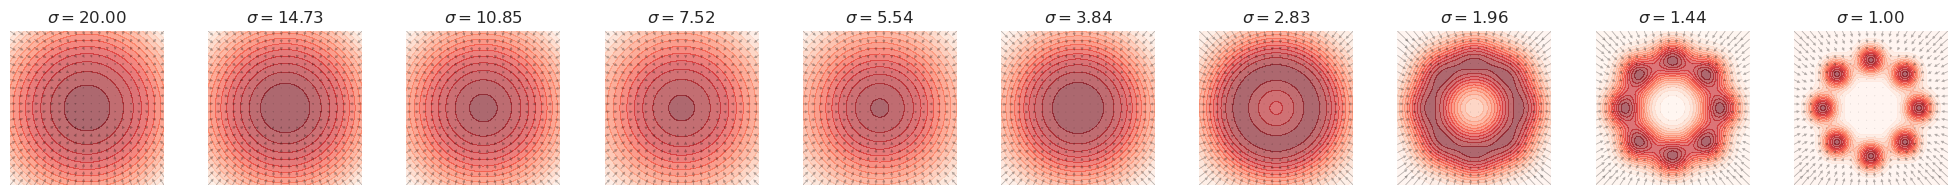

Generating GIF...


/tmp/ipykernel_810178/935653853.py:70: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


GIF saved as annealed_scores_ring.gif


In [31]:
teacher_anneal_ring = GMMDistAnneal(dim=2, dist_type='ring')
sigmas = torch.tensor(np.exp(np.linspace(np.log(20), 0., 50))).float().to(device)
score_anneal_ring = train_annealed_langevin_model(teacher_anneal_ring, sigmas)
visualize_annealed_langevin_model(score_anneal_ring, teacher_anneal_ring, sigmas, left_bound, right_bound, save_name='annealed_scores_ring.gif')

Results of the annealed Langevin dynamics model on the Ring dataset. Remarks:
*   The annealed Langevin dynamics successfully samples from all 8 modes of the ring distribution.
*   The samples are much more evenly distributed compared to the single-scale case.
*   The sequence of noise scales allows the model to "bridge" the low-density regions between the Gaussians, enabling better mixing.